# Visualize Forecasts
This notebook visualizes the forecasts used as input for the optimization problem.

### Imports 

In [16]:
import os
import sys
sys.path.append('..')
from optimization.input_data import load_forecasts, load_params, preprocess_data, load_costs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from optimization.utils import cdf_formula, pdf_formula
from scipy.integrate import quad
os.getcwd()

'c:\\Users\\Paulina\\OneDrive\\Desktop\\UNIVERSITYMASTER\\Masterarbeit\\Code2025\\Day-Ahead-Battery-Scheduling\\forecasting'

In [17]:
def custom_x_axis_formatter(x, pos, time):
    ''' Custom formatter for the x-axis. '''
    # Convert position (x) to index and get the corresponding timestamp
    index = int(x) if x < len(time) else len(time) - 1
    date = time[index]  # Access the corresponding Timestamp
    if date.hour == 0 or index == 0:  # First tick of the day
        return date.strftime('%d/%m/%Y\n%H:%M')  # Show "DD/MM HH"
    else:
        return date.strftime('%H:%M')  # Otherwise show "HH:MM"
    
def custom_x_axis_formatter_2(x, pos, time):
    ''' Custom formatter for the x-axis. '''
    # Convert position (x) to index and get the corresponding timestamp
    index = int(x) if x < len(time) else len(time) - 1
    date = time[index]  # Access the corresponding Timestamp
    return date.strftime('%H:%M')  # Otherwise show "HH:MM"
    

def get_file_path(filename):
    ''' Get file path to store plots in a temporary folder for logging in mlflow. '''
    temp_folder = os.path.join(os.getcwd(), 'temporary_folder')
    os.makedirs(temp_folder, exist_ok=True)

    return os.path.join(temp_folder, filename)

### Load Data

In [18]:
# Example 1: Normal distribution
# fc_folder = '../data/parametric_forecasts/normal_dist_forecast_2024-10-31/'
# params_path = '../data/parameters/params_normal_dist.json'
# timeframe = ['2017-05-18 00:00:00', '2017-05-18 23:00:00']

# Example 2: Sum of two gaussian distributions (reproduce paper results)
fc_folder = '../data/parametric_forecasts/gmm2_forecast_2025-04-03_hour_6/' 

params_path = '../data/parameters/params_case2.json'
timeframe1 = ['2017-05-02 06:00:00', '2017-05-03 05:00:00'] # GT much more negative than forecasts
#timeframe2 = ['2017-07-02 06:00:00', '2017-07-04 05:00:00'] # GT closer to zero than forecasts
#timeframe3 = ['2017-06-09 06:00:00', '2017-06-11 05:00:00']
timeframe = ['2017-06-09 06:00:00', '2017-06-10 05:00:00']
timeframe = timeframe1


# Load data
forecasts = load_forecasts(fc_folder, timeframe)
params = load_params(params_path)
input_data = preprocess_data(forecasts, params)


gt = pd.read_csv('../data/ground_truth/residential4_prosumption.csv', index_col=0)
gt.index = pd.to_datetime(gt.index)
if timeframe is not None:
    gt = gt.loc[timeframe[0]:timeframe[1]]

In [19]:
### Loading costs
costs_folder = '../data/electricity_costs/'
costs = load_costs(costs_folder, timeframe)
print(costs)

x=[[8.027794480260717, 7.809599908384714, 7.843233908723243, 7.514860777868128, 8.253717440453324, 8.518219941282847, 6.961519852044359, 6.610996880580462, 6.455895511228274, 6.4071991127606935, 6.4060940227568, 6.40609399830842, 6.406093998271592, 6.406094022749887, 6.406159338358688], [9.001464697433088, 8.627659929950624, 8.842958226164274, 7.869981527481773, 7.173771884596662, 6.797297931939219, 6.551681918634867, 6.350804537276656, 6.180924423296679, 6.029873415789641, 5.8980105854066744, 5.780801102079819, 5.671725610077551, 5.576448415594604, 5.489451729417533], [8.487130463568652, 8.031170480488138, 8.218238809177716, 9.496165985739514, 8.17093192474565, 8.749585587058514, 9.04233969792765, 8.743994308089936, 8.496991012422638, 8.656848269718841, 7.634295847137107, 6.651528837796577, 6.460591083053444, 6.306753359385245, 6.1781025444962605], [8.627146062714335, 8.706105268997739, 8.665024096505881, 8.62120709535866, 8.537221173107293, 8.365811414420575, 8.488763253794847, 7.292325533116726, 7.110397718111116, 7.037168958531058, 6.9871190767936895, 6.9479804519700945, 6.918117598448337, 6.896283741977923, 6.881093412752533]]        
y=[[10.00000009999893, 11.428571542855545, 12.85714298571222, 14.285714428573073, 15.714285871425622, 17.142857314134645, 18.57142875618839, 20.000000183977928, 21.428571605112165, 22.857142719499077, 23.499416924706768, 23.192376864793438, 24.704993504892265, 23.85459286744573, 24.655105051888366], [10.000000099998474, 11.428571542855249, 12.857142985708588, 14.28571442520201, 15.714285868714786, 17.142857302327954, 18.571428740279813, 20.00000018017199, 21.428571634811675, 22.85714306048077, 24.28571449996117, 25.71428595978886, 27.142857378743976, 28.571428817745996, 30.000000256549733], [10.000000099998333, 11.428571542842509, 12.857142985712917, 14.28571442856146, 15.714285871425124, 17.142857314283777, 18.571428757140772, 20.000000199997736, 21.428571642840563, 22.857143085708408, 24.285714528568725, 25.714285956497022, 27.14285739255689, 28.57142883226545, 30.000000271578006], [10.000000099999625, 11.428571542856112, 12.857142985713127, 14.285714428570524, 15.714285871426855, 17.14285731428382, 18.571428757141458, 20.000000188442932, 21.428571608682997, 22.85714302251739, 24.285714499185783, 25.714285867228604, 27.142857363587904, 28.571428661397864, 30.00000000943898]]
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

[2017-05-02 06:00:00    33.95
2017-05-02 07:00:00    38.97
2017-05-02 08:00:00    39.98
2017-05-02 09:00:00    35.84
2017-05-02 10:00:00    34.85
2017-05-02 11:00:00    33.47
2017-05-02 12:00:00    31.04
2017-05-02 13:00:00    30.78
2017-05-02 14:00:00    30.04
2017-05-02 15:00:00    30.41
2017-05-02 16:00:00    30.43
2017-05-02 17:00:00    31.02
2017-05-02 18:00:00    34.97
2017-05-02 19:00:00    38.52
2017-05-02 20:00:00    38.57
2017-05-02 21:00:00    35.23
2017-05-02 22:00:00    33.34
2017-05-02 23:00:00    28.46
2017-05-03 00:00:00    28.59
2017-05-03 01:00:00    27.43
2017-05-03 02:00:00    27.48
2017-05-03 03:00:00    28.05
2017-05-03 04:00:00    30.35
2017-05-03 05:00:00    31.95
Name: Preis (EUR/MWh, EUR/tCO2), dtype: object]
(4, 15)
(4, 15)


### Plot Expected Prosumption


In [20]:
fc_exp = input_data['fc_exp']
gt_series = gt.iloc[:,0]

# Create the figure
fig = go.Figure()

# Add the line plot
fig.add_trace(go.Scatter(x=fc_exp.index, y=fc_exp.values, mode='lines', name='Expected Prosumption'))
fig.add_trace(go.Scatter(x=gt_series.index, y=gt_series.values, mode='lines', name='Ground truth'))

# Update layout for better visualization
fig.update_layout(
    title='Expected Prosumption vs Ground Truth',
    xaxis_title='Time',
    yaxis_title='Prosumption [kWh]',
    xaxis=dict(
        tickformat='%H:%M',
        tickmode='auto',
        nticks=12,  # Reduce the number of ticks to make the plot more compact
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    annotations=[
        dict(
            xref='paper', yref='paper', x=0.05, y=0.95,
            text="Positive prosumption refers to power consumption.",
            showarrow=False,
            bordercolor='black',
            borderwidth=1,
            borderpad=4,
            bgcolor='white',
            opacity=0.8
        )
    ],
    width=800,  # Adjust the width of the plot
    height=500  # Adjust the height of the plot
)


# Show the plot
fig.show()

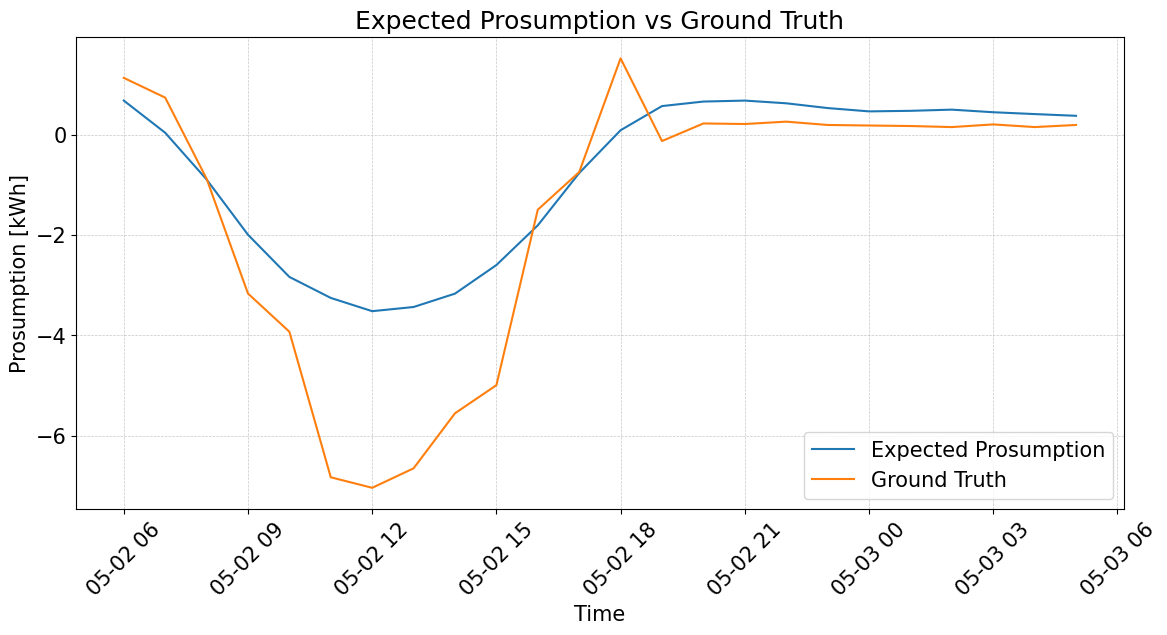

In [21]:
import matplotlib.dates as mdates

# Plot expcted prosumption with matplotlib

fc_exp = input_data['fc_exp']
gt_series = gt.iloc[:,0]

# Create the plot
plt.figure(figsize=(12, 6))

plt.plot(fc_exp.index, fc_exp.values, label='Expected Prosumption', linestyle='-', marker='', color='tab:blue')
plt.plot(gt_series.index, gt_series.values, label='Ground Truth', linestyle='-', marker='', color='tab:orange')

# Formatting
plt.title('Expected Prosumption vs Ground Truth')
plt.xlabel('Time')
plt.ylabel('Prosumption [kWh]')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()


# Rotate
plt.xticks(rotation=45)

# Save figure
file_path = get_file_path('prosumption_deviation_day3.png')
plt.savefig(file_path, dpi=300, bbox_inches = 'tight')

# Show the plot
plt.show()

### Plot Prosumption Uncertainties

In [22]:
uncertainty_form = input_data['pdf/cdf name']
uncertainty_weights = input_data['fc_weights']

uncertainty_form = 'sum-2-gaussian-distributions'
# Iterate through the uncertainty weights
pdf = pdf_formula(uncertainty_form)

pdfs_dist = []
x = np.linspace(-30, 30, 3000)
x_total = []
for t in uncertainty_weights.index:
    weights = uncertainty_weights.loc[t]

    y = []
    x_new = []
    for xi in x:
        try:
            yi = pdf(xi, *weights)
            y.append(yi)
            x_new.append(xi)
        except OverflowError:
            continue

    pdfs_dist.append(y)
    x_total.append(x_new)

# Create the figure
fig = go.Figure()

# Add each timestep as a trace with its time as the label
for i, t in enumerate(uncertainty_weights.index):
    fig.add_trace(go.Scatter(x=x_total[i], y=pdfs_dist[i], mode='lines', name=f'Time {t.strftime('%H:%M %d-%m-%Y')}'))

fig.update_layout(
    title='Probability Density Functions - All Time Steps',
    xaxis_title='Prosumption-Uncertainty [kW]',
    yaxis_title='Probability Density',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray', range=[-20, 20]),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray', range=[-0.1, 5]),
    legend_title_text='Timesteps',
    #width=1600,  # Adjust the width of the plot
    #height=1000  # Adjust the height of the plot
)

fig.show()

### Validate the PDFs
The PDFs defined by the forecasted weights need to represent a valid PDF. They all need to be non-negative and integrate to one.

In [23]:
from optimization.utils import dynamic_bounds

uncertainty_weights = input_data['fc_weights']
dynamic_bound_low, dynamic_bound_high = dynamic_bounds((-30.0, 30.0), pdf, uncertainty_weights) # .loc['2017-05-18 06:00:00':'2017-05-18 07:00:00']
dynamic_bound_low_list = list(dynamic_bound_low.values())
dynamic_bound_high_list = list(dynamic_bound_high.values())
pdf = pdf_formula(uncertainty_form)


for i, t in enumerate(uncertainty_weights.index):
    weights = uncertainty_weights.loc[t]

    try:
        total_prob, _ = quad(lambda x: pdf(x, *weights), dynamic_bound_low_list[i], dynamic_bound_high_list[i]) # bounds should be dynamic. Lower bounds => Less OverflowErrors but less accurate
    except OverflowError:
        print(f'OverflowError at time {t}')
        continue
    
    if np.abs(total_prob - 1) > 1e-6:
        print('Warning: Total probability is not 1 => Adjust bounds')
    print(f'Time {t}: Total probability = {total_prob:.10f}')

# Check non-negativity via sampling
x = np.linspace(-3, 3, 20000)
for i, t in enumerate(uncertainty_weights.index):
    weights = uncertainty_weights.loc[t]
    y = []
    for xi in x:
        try:
            yi = pdf(xi, *weights)
            y.append(yi)
        except OverflowError:
            continue
    if np.any(np.array(y) < 0):
        print(f'!!!!!!!!!!!!!!!!!!!!!! Warning: Negative probability density at time {t}')

Time 2017-05-02 06:00:00: Total probability = 0.9999999988
Time 2017-05-02 07:00:00: Total probability = 0.9999999985
Time 2017-05-02 08:00:00: Total probability = 0.9999999976
Time 2017-05-02 09:00:00: Total probability = 0.9999999966
Time 2017-05-02 10:00:00: Total probability = 0.9999999957
Time 2017-05-02 11:00:00: Total probability = 0.9999999954
Time 2017-05-02 12:00:00: Total probability = 0.9999999951
Time 2017-05-02 13:00:00: Total probability = 0.9999999945
Time 2017-05-02 14:00:00: Total probability = 0.9999999946
Time 2017-05-02 15:00:00: Total probability = 0.9999999953
Time 2017-05-02 16:00:00: Total probability = 0.9999999959
Time 2017-05-02 17:00:00: Total probability = 0.9999999968
Time 2017-05-02 18:00:00: Total probability = 0.9999999975
Time 2017-05-02 19:00:00: Total probability = 0.9999999984
Time 2017-05-02 20:00:00: Total probability = 0.9999999982
Time 2017-05-02 21:00:00: Total probability = 0.9999999982
Time 2017-05-02 22:00:00: Total probability = 0.99999999

### Paper Plots

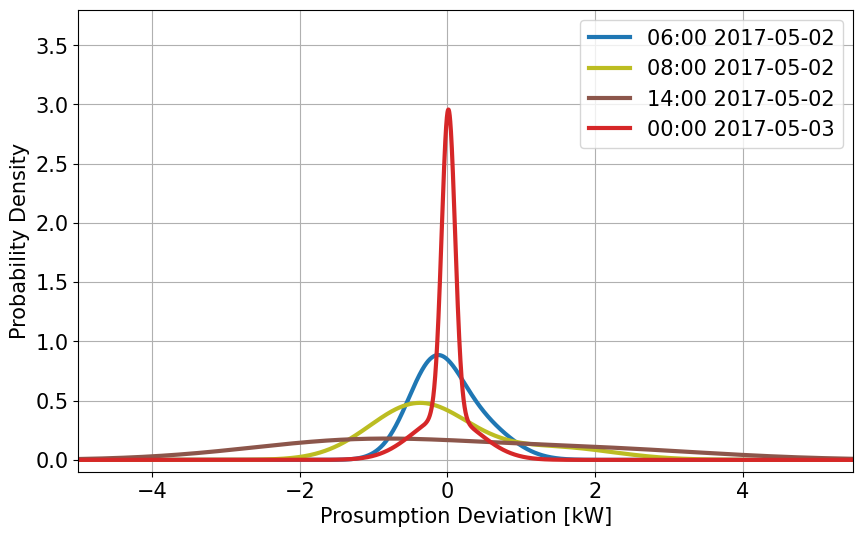

In [24]:
times_to_plot = ['2017-05-02 06:00:00', '2017-05-02 08:00:00', '2017-05-02 14:00:00', '2017-05-03 00:00:00']
fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(-6, 6, 10000)
count = 0
colors = ['tab:blue', 'tab:olive', 'tab:brown', 'tab:red']
uncertainty_form = input_data['pdf/cdf name']
uncertainty_weights = input_data['fc_weights']
for t in times_to_plot:
    weights = uncertainty_weights.loc[t]
    y_vals = []
    x_vals_plottable = []
    for xi in x:
        try:
            yi = pdf(xi, *weights)
            y_vals.append(yi)
            x_vals_plottable.append(xi)

        except OverflowError:
            continue
    hours = pd.to_datetime(t).hour
    # reformat hour to 2 digits
    if hours < 10:
        hours = f'0{hours}'
    date = pd.to_datetime(t).date()
    ax.plot(x_vals_plottable, y_vals, linewidth=3, label=f'{hours}:00 {date}', color=colors[count])
    count += 1
plt.grid()
plt.rcParams.update({'font.size': 15})
ax.set_xlim(-5, 5.5)
ax.set_ylim(-0.1, 3.8)
plt.xlabel('Prosumption Deviation [kW]')
plt.ylabel('Probability Density')
plt.legend()

# Save figure
file_path = get_file_path('prosumption_deviation.png')
plt.savefig(file_path, dpi=300, bbox_inches = 'tight')

plt.show()

C:\Users\Paulina\AppData\Local\Temp\ipykernel_12464\657947229.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



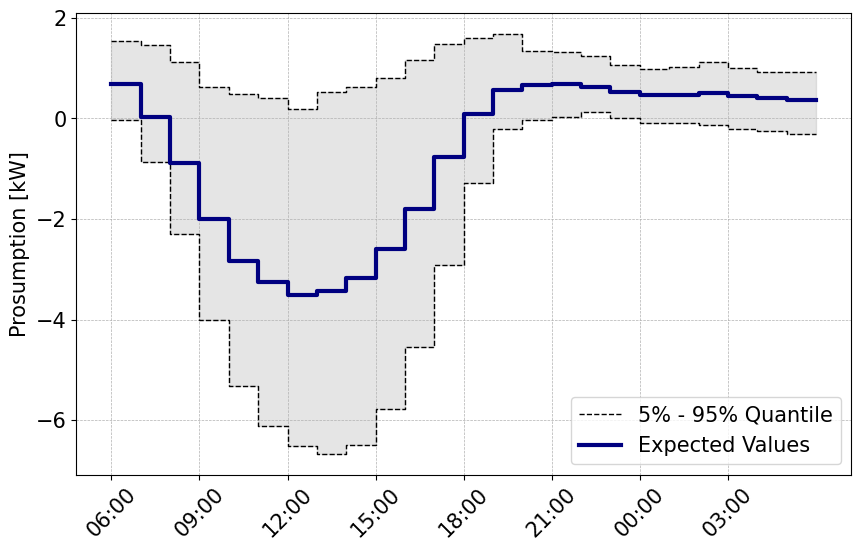

In [25]:
plt.rcParams.update({'font.size': 15})
quantiles = [0.05, 0.95, 0.5]

fig, ax = plt.subplots(figsize=(10, 6))

time = [str(t.hour) for t in fc_exp.index]
time.append(str(int(time[-1])+0.95))  # Repeat the last time point
exp_values = list(fc_exp.values)
exp_values.append(fc_exp.values[-1]) 

gt_values = list(gt.values)
gt_values.append(gt.values[-1])


ordered_time =tuple(fc_exp.index)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: custom_x_axis_formatter_2(x, pos, ordered_time)))

# Uncertainty band
uncertainty_form = input_data['pdf/cdf name']
uncertainty_weights = input_data['fc_weights']

pdf = pdf_formula(uncertainty_form)
cdf = cdf_formula(uncertainty_form)

x = np.linspace(-15, 15, 10000)
prosumption_quant_low = []
prosumption_quant_high = []
prosumption_quant_mid = []
n=10

for i in range(len(uncertainty_weights)):
    w1, w2, w3, w4, w5, w6 = uncertainty_weights[i]

    for xi in x:
        #try:
        cdf_val = cdf(xi, w1, w2, w3, w4, w5, w6,n)
        if cdf_val >= quantiles[0]:
            prosumption_quant_low.append(xi)
            break

    for xi in reversed(x):
        cdf_val = cdf(xi, w1, w2, w3, w4, w5, w6,n)
        if cdf_val <= quantiles[1]:
            prosumption_quant_high.append(xi)
            break
    
    if len(quantiles) == 3:
        for xi in x:
            cdf_val = cdf(xi, w1, w2, w3, w4, w5, w6,n)
            if cdf_val >= quantiles[2]:
                prosumption_quant_mid.append(xi)
                break

if prosumption_quant_mid is not None:
    prosumption_quant_mid.append(prosumption_quant_mid[-1])
prosumption_quant_low.append(prosumption_quant_low[-1])
prosumption_quant_high.append(prosumption_quant_high[-1])

# Shift the deviations to the expected prosumption
prosumption_quant_low = exp_values + np.array(prosumption_quant_low)
prosumption_quant_high = exp_values + np.array(prosumption_quant_high)

plt.step(time, prosumption_quant_low, label=f'{int(100*quantiles[0])}% - {int(100*quantiles[1])}% Quantile', color='black', linestyle='--', where='post', linewidth=1.0)
plt.step(time, prosumption_quant_high, color='black', linestyle='--', where='post', linewidth=1.0)
ax.fill_between(time, prosumption_quant_low, prosumption_quant_high, color='grey', alpha=0.2, step='post')

if prosumption_quant_mid is not None:
    prosumption_quant_mid = exp_values + np.array(prosumption_quant_mid)
    #plt.step(time, prosumption_quant_mid, label='Median', color='navy', where='post', linewidth=3.0)
    plt.step(time, exp_values, label='Expected Values', color='navy', where='post', linewidth=3)


plt.ylabel('Prosumption [kW]')
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.xticks(np.arange(0, 24, 2), rotation=45)
plt.xticks(np.arange(0,24,3), rotation=45)

# Save figure
file_path = get_file_path('expected_prosumption.png')
plt.savefig(file_path, dpi=300, bbox_inches = 'tight')

plt.show()


In [26]:
colors = plt.cm.viridis(np.linspace(0, 1, 24))
print(colors)
print(colors[23])

[[0.267004 0.004874 0.329415 1.      ]
 [0.279566 0.067836 0.391917 1.      ]
 [0.283187 0.125848 0.44496  1.      ]
 [0.278012 0.180367 0.486697 1.      ]
 [0.265145 0.232956 0.516599 1.      ]
 [0.246811 0.283237 0.535941 1.      ]
 [0.225863 0.330805 0.547314 1.      ]
 [0.204903 0.375746 0.553533 1.      ]
 [0.183898 0.422383 0.556944 1.      ]
 [0.166617 0.463708 0.558119 1.      ]
 [0.150476 0.504369 0.55743  1.      ]
 [0.135066 0.544853 0.554029 1.      ]
 [0.122606 0.585371 0.546557 1.      ]
 [0.120638 0.625828 0.533488 1.      ]
 [0.14021  0.665859 0.513427 1.      ]
 [0.185783 0.704891 0.485273 1.      ]
 [0.259857 0.745492 0.444467 1.      ]
 [0.344074 0.780029 0.397381 1.      ]
 [0.440137 0.811138 0.340967 1.      ]
 [0.545524 0.838039 0.275626 1.      ]
 [0.657642 0.860219 0.203082 1.      ]
 [0.772852 0.877868 0.131109 1.      ]
 [0.886271 0.892374 0.095374 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]
[0.993248 0.906157 0.143936 1.      ]
